In [21]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow_probability.python.distributions import kl_divergence

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [5]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [114]:
hf = h5py.File('/mnt/data/HSC/HSC_v9/five_band_image120x120.hdf5', 'r')

In [115]:
n = 10000

In [116]:
x = hf["image"][0:n]
y = hf["specz"][0:n]

In [117]:
x.shape

(10000, 5, 120, 120)

In [127]:
x = np.transpose(x,(0,2,3,1))
max_value = np.max(x)
x_new = np.true_divide(x,max_value) # Convert to valid input tensor, normalize

In [128]:
hf.close()

In [129]:
x_train, x_test, y_train, y_test = train_test_split(x_new,y,test_size=0.2)

In [130]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [131]:
kl_divergence_function = lambda q, p, _: kl_divergence(q, p) / n

In [147]:
model_variational = Sequential([
    tf.keras.Input(shape=(120,120,5),name="basket"),
    
    tfp.layers.Convolution2DFlipout(100, kernel_size=5, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1a", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    
    tfp.layers.Convolution2DFlipout(100, kernel_size=5, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1b", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    
    tfp.layers.Convolution2DFlipout(100, kernel_size=5, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1c", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    
    tfp.layers.Convolution2DFlipout(100, kernel_size=5, strides=(3,3), data_format="channels_last", 
                                    padding="same", activation=tf.nn.relu, name="conv_tfp_1d", 
                                    kernel_divergence_fn=kl_divergence_function),
    tf.keras.layers.MaxPool2D(strides=(2,2), pool_size=(2,2), padding="same"),
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(1, kernel_divergence_fn=kl_divergence_function),
])


In [148]:
learning_rate = 1.0e-3
model_variational.compile(loss='mse',
              optimizer='Adam',
              metrics=['mse'])

In [149]:
model_variational.fit(x = x_train, y = y_train, batch_size = 500, epochs = 50)

Epoch 1/50
16/16 [==============================] - 3s 63ms/step - loss: 193.0741 - mse: 0.6395
Epoch 2/50
16/16 [==============================] - 1s 58ms/step - loss: 191.7318 - mse: 0.4912
Epoch 3/50
16/16 [==============================] - 1s 57ms/step - loss: 190.5266 - mse: 0.4844
Epoch 4/50
16/16 [==============================] - 1s 54ms/step - loss: 189.3299 - mse: 0.4837
Epoch 5/50
16/16 [==============================] - 1s 55ms/step - loss: 188.1339 - mse: 0.4800
Epoch 6/50
16/16 [==============================] - 1s 57ms/step - loss: 186.9461 - mse: 0.4814
Epoch 7/50
16/16 [==============================] - 1s 58ms/step - loss: 185.7555 - mse: 0.4769
Epoch 8/50
16/16 [==============================] - 1s 57ms/step - loss: 184.5717 - mse: 0.4767
Epoch 9/50
16/16 [==============================] - 1s 58ms/step - loss: 183.3876 - mse: 0.4741
Epoch 10/50
16/16 [==============================] - 1s 56ms/step - loss: 182.2101 - mse: 0.4760
Epoch 11/50
16/16 [====================

In [150]:
model_variational.predict(np.array([x_test[0],x_test[1]]))

array([[0.66387993],
       [0.5815656 ]], dtype=float32)

In [153]:
y_test_predict = model_variational.predict(x_test)
y_test_prediction = []

for i in range(len(y_test)):
    y_test_prediction.append(y_test_predict[i][0])

y_test_prediction = np.asarray(y_test_prediction)

y_test_spectro = np.asarray(y_test)

In [154]:
y_test_spectro

array([0.43696001, 2.15862012, 0.50957   , ..., 0.72834003, 0.21884   ,
       0.62910002])

In [155]:
y_test_prediction

array([0.5496454 , 0.6170847 , 0.63680893, ..., 0.7542631 , 0.6289184 ,
       0.549116  ], dtype=float32)

In [156]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_test_spectro,y_test_prediction])).astype('float32')
z = gaussian_kde(xy)(xy)

(0.0, 2.0)

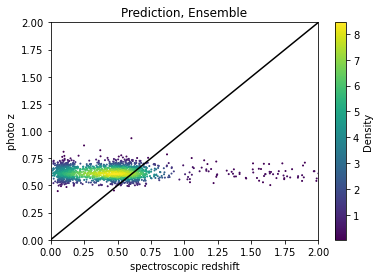

In [157]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test_spectro, y_test_prediction, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot, label = 'Density')
plt.title('Prediction, Ensemble')
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 2], [0, 2],color = 'black')
plt.xlim([0, 2])
plt.ylim([0, 2])